# Import modules

In [1]:
import numpy as np
import pickle
from pathlib import Path
from tqdm import trange


import flygym.common
import flygym.mujoco
import flygym.mujoco.preprogrammed


from nmf_test import (
    NeuromechflyGrooming,
    plot_state_and_contacts,
)

from IPython.display import Video

from flygym.mujoco.examples.rule_based_controller import PreprogrammedSteps

# Define Dust Class with front and back elements

In [2]:
class NeuromechflyDust(NeuromechflyGrooming):
    def __init__(
        self,
        back,
        sim_params,
        init_dust_level=5.0,
        saturation_level=10.0,
        ant_decay=0.05,
        abdomen_decay=0.01,
        eye_decay=0.01,
        foreleg_decay=0.01,
        hindleg_decay=0.01,
        dusted_areas = [],
        touch_thr=1.0,
    ):
        self.back = back
        if self.back == 0:
            self.dusted_areas = ["R_antenna", "L_antenna", "RF_leg", "LF_leg", "R_eye", "L_eye"]
            self.bodies_in_app = {
                "R_antenna": ["RPedicel", "RArista", "RFuniculus"],
                "L_antenna": ["LPedicel", "LArista", "LFuniculus"],
                "RF_leg": [
                    "RFTarsus1",
                    "RFTarsus2",
                    "RFTarsus3",
                    "RFTarsus4",
                    "RFTarsus5",
                    "RFTibia",
                ],
                "LF_leg": [
                    "LFTarsus1",
                    "LFTarsus2",
                    "LFTarsus3",
                    "LFTarsus4",
                    "LFTarsus5",
                    "LFTibia",
                ],
                "R_eye": ["REye"],
                "L_eye": ["LEye"],
            }
        else:
            self.dusted_areas = ["RH_leg", "LH_leg", "Abdomen"]
            self.bodies_in_app = {
                "RH_leg": [
                    "RHTarsus1",
                    "RHTarsus2",
                    "RHTarsus3",
                    "RHTarsus4",
                    "RHTarsus5",
                    "RHTibia",
                ],
                "LH_leg": [
                    "LHTarsus1",
                    "LHTarsus2",
                    "LHTarsus3",
                    "LHTarsus4",
                    "LHTarsus5",
                    "LHTibia",
                ],
                "Abdomen": [
                    "A1A2",
                    "A3",
                    "A4",
                    "A5",
                            ],
            }

        self.dusted_bodies = [
            body for area in self.dusted_areas for body in self.bodies_in_app[area]
        ]
        print("dusted_bodies", self.dusted_bodies)
        # check if the dust level is a list
        self.saturation_level = saturation_level
        if isinstance(init_dust_level, list):
            self.dust_level = np.array(init_dust_level)
        else:
            self.dust_level = np.ones(len(self.dusted_areas)) * init_dust_level
        self.dust_level = np.clip(self.dust_level, 0.0, self.saturation_level)

        self.touch_thr = touch_thr
        if self.back == 0:
            self.ant_dust_decay = ant_decay
            self.eye_dust_decay = eye_decay
            self.foreleg_dust_decay = foreleg_decay
        else:
            self.hindleg_dust_decay = hindleg_decay
            self.abdomen_dust_decay = abdomen_decay

        touch_sensors_locations = []
        self.touch_sensors_ids = []
        self.appendage_touch_sensors = [[]] * len(self.dusted_areas)
        for i, area in enumerate(self.dusted_areas):
            n_touch_sensors_previous = len(touch_sensors_locations)
            if area in self.bodies_in_app:
                touch_sensors_locations += self.bodies_in_app[area]
            else:
                raise ValueError("Unknown dusted area")
            self.appendage_touch_sensors[i] = np.arange(
                n_touch_sensors_previous, len(touch_sensors_locations)
            )

        self.baseline_rgba = np.array([1.0, 1.0, 1.0, 1.0])
        self.no_dust_color = np.array([0.59, 0.39, 0.12, 1.0])
        self.full_dust_color = np.array([0.0, 1.0, 0.0, 1.0])

        super().__init__(
            sim_params=sim_params,
            groom_collision=True,
            touch_sensor_locations=touch_sensors_locations,
        )

        self.update_segment_aspect()

    def _set_geom_colors(self):
        if self.back == 0:
            self.areas_materials = {}
            self.areas_materials["RF_leg"] = []
            self.areas_materials["LF_leg"] = []
            for type_, specs in self._mujoco_config["appearance"].items():
                
            # If part of the dusted bodies, set the color to the baseline
                dusted_bodies_type_match = [
                    db[2:-1].lower() in type_ for db in self.dusted_bodies
                ]
                if (
                    "antenna" in type_
                    or any(dusted_bodies_type_match)
                    and not "arista" in type_
                ):
                    specs["material"]["rgba"] = self.baseline_rgba
                    if type_ == "eye":
                        specs["texture"] = self._mujoco_config["appearance"]["antenna"][
                            "texture"
                        ]
                        specs["texture"]["rgb1"] = self.baseline_rgba[:3]
                        specs["texture"]["rgb2"] = self.baseline_rgba[:3]
                        specs["texture"]["width"] = 1e6
                        specs["texture"]["height"] = 1e6
                        specs["texture"]["random"] = 1e-5
                    elif specs["texture"] is not None:
                        specs["texture"]["rgb1"] = self.baseline_rgba[:3]
                        specs["texture"]["rgb2"] = self.baseline_rgba[:3]

        else:
        
            self.areas_materials = {}
            self.areas_materials["RH_leg"] = []
            self.areas_materials["LH_leg"] = []

            for type_, specs in self._mujoco_config["appearance"].items():
                # If part of the dusted bodies, set the color to the baseline
                dusted_bodies_type_match = [
                    db[2:-1].lower() in type_ for db in self.dusted_bodies
                ]
                if (
                    "a12345" in type_
                    or any(dusted_bodies_type_match)
                ):
                    specs["material"]["rgba"] = self.baseline_rgba
                    if type_ == "a6":
                        specs["texture"] = self._mujoco_config["appearance"]["a12345"][
                            "texture"
                        ]
                        specs["texture"]["rgb1"] = self.baseline_rgba[:3]
                        specs["texture"]["rgb2"] = self.baseline_rgba[:3]
                        specs["texture"]["width"] = 1e6
                        specs["texture"]["height"] = 1e6
                        specs["texture"]["random"] = 1e-5
                    elif specs["texture"] is not None:
                        specs["texture"]["rgb1"] = self.baseline_rgba[:3]
                        specs["texture"]["rgb2"] = self.baseline_rgba[:3]

        

            # Define texture and material
            if specs["texture"] is not None:
                self.model.asset.add(
                    "texture",
                    name=f"{type_}_texture",
                    builtin=specs["texture"]["builtin"],
                    mark="random",
                    width=specs["texture"]["size"],
                    height=specs["texture"]["size"],
                    random=specs["texture"]["random"],
                    rgb1=specs["texture"]["rgb1"],
                    rgb2=specs["texture"]["rgb2"],
                    markrgb=specs["texture"]["markrgb"],
                )
            self.model.asset.add(
                "material",
                name=f"{type_}_material",
                texture=f"{type_}_texture" if specs["texture"] is not None else None,
                rgba=specs["material"]["rgba"],
                specular=0.0,
                shininess=0.0,
                reflectance=0.0,
                texuniform=True,
            )
            #Apply to geoms
            for segment in specs["apply_to"]:
                geom = self.model.find("geom", segment)
                if geom is None:
                    geom = self.model.find("geom", f"{segment}")
                geom.material = f"{type_}_material"

    def get_observation(self):
        obs = super().get_observation()

        appendage_touch = [
            np.sum(obs["touch_sensors"][touch_sensors])
            for touch_sensors in self.appendage_touch_sensors
        ]

        if self.back == 0:
            R_antenna_contact = np.mean(
                appendage_touch[self.dusted_areas.index("R_antenna")]
            )
            L_antenna_contact = np.mean(
                appendage_touch[self.dusted_areas.index("L_antenna")]
            )
            RF_leg_contact = np.mean(appendage_touch[self.dusted_areas.index("RF_leg")])
            LF_leg_contact = np.mean(appendage_touch[self.dusted_areas.index("LF_leg")])
            R_eye_contact = np.mean(appendage_touch[self.dusted_areas.index("R_eye")])
            L_eye_contact = np.mean(appendage_touch[self.dusted_areas.index("L_eye")])
            Abdomen_contact = 0.0
            RH_leg_contact = 0.0
            LH_leg_contact = 0.0
        
        else:
            R_antenna_contact = 0.0
            L_antenna_contact = 0.0
            RF_leg_contact = 0.0
            LF_leg_contact = 0.0
            R_eye_contact = 0.0
            L_eye_contact = 0.0
            Abdomen_contact = np.mean(
                appendage_touch[self.dusted_areas.index("Abdomen")]
            )
            RH_leg_contact = np.mean(appendage_touch[self.dusted_areas.index("RH_leg")])
            LH_leg_contact = np.mean(appendage_touch[self.dusted_areas.index("LH_leg")])

        if self.back == 0:
            is_Rantenna_grooming = (
                R_antenna_contact > self.touch_thr
                and RF_leg_contact > self.touch_thr
                and LF_leg_contact > self.touch_thr
                and not self.back
            )

            is_Lantenna_grooming = (
                L_antenna_contact > self.touch_thr
                and RF_leg_contact > self.touch_thr
                and LF_leg_contact > self.touch_thr
                and not self.back
            )
            
            is_eye_grooming = (
                R_eye_contact > self.touch_thr
                and RF_leg_contact > self.touch_thr
                and L_eye_contact > self.touch_thr
                and LF_leg_contact > self.touch_thr
                and not self.back
            )

            is_foreleg_grooming = (
                RF_leg_contact > self.touch_thr
                and LF_leg_contact > self.touch_thr
                and not is_Rantenna_grooming
                and not is_Lantenna_grooming
                and not is_eye_grooming
                and not self.back
            )

            is_Abdomen_grooming = self.back

            is_hindleg_grooming = self.back

        else:
            is_Rantenna_grooming = not self.back
            is_Lantenna_grooming = not self.back
            is_eye_grooming = not self.back
            is_foreleg_grooming = not self.back

            is_Abdomen_grooming = (
                Abdomen_contact > self.touch_thr
                and RH_leg_contact > self.touch_thr
                and LH_leg_contact > self.touch_thr
                and self.back
            )

            is_hindleg_grooming = (
                RH_leg_contact > self.touch_thr
                and LH_leg_contact > self.touch_thr
                and not is_Abdomen_grooming
                and self.back
            )

        self.update_dust_level(
            is_foreleg_grooming,
            is_Rantenna_grooming,
            is_Lantenna_grooming,
            is_eye_grooming,
            R_antenna_contact,
            L_antenna_contact,
            RF_leg_contact,
            LF_leg_contact,
            R_eye_contact,
            L_eye_contact,
            is_Abdomen_grooming,
            is_hindleg_grooming,
            Abdomen_contact,
            RH_leg_contact,
            LH_leg_contact,
        )

        self.update_segment_aspect()

        # add curr behavior
        obs["is_foreleg_grooming"] = is_foreleg_grooming
        obs["is_Rantenna_grooming"] = is_Rantenna_grooming
        obs["is_Lantenna_grooming"] = is_Lantenna_grooming
        obs["is_eye_grooming"] = is_eye_grooming
        obs["is_hindleg_grooming"] = is_hindleg_grooming
        obs["is_Abdomen_grooming"] = is_Abdomen_grooming

        assert all(self.dust_level >= 0.0) and all(
            self.dust_level <= self.saturation_level
        ), f"Dust level out of bounds: {self.dust_level}"
        # add dust level
        obs["dust_level"] = self.dust_level

        return obs

    def update_segment_aspect(self):
        # change body rgba depending on dust level
        for app, dl in zip(self.dusted_areas, self.dust_level):
            for body in self.bodies_in_app[app]:
                if not "Arista" in body:
                    norm_dl = (dl.copy() - 0.0) / (self.saturation_level - 0.0)
                    self.physics.named.model.geom_rgba[
                        f"Animat/{body}"
                    ] = self.interp_color(norm_dl)

    def interp_color(self, dust_level):
        return (
            self.no_dust_color
            + (self.full_dust_color - self.no_dust_color) * dust_level
        )

    def update_dust_level(
        self,
        is_foreleg_grooming,
        is_Rantenna_grooming,
        is_Lantenna_grooming,
        is_eye_grooming,
        R_antenna_contact,
        L_antenna_contact,
        RF_leg_contact,
        LF_leg_contact,
        R_eye_contact,
        L_eye_contact,
        is_Abdomen_grooming,
        is_hindleg_grooming,
        Abdomen_contact,
        RH_leg_contact,
        LH_leg_contact,
    ):
        is_saturated = self.dust_level >= self.saturation_level
        saturated_app = [
            self.dusted_areas[i] for i, sat in enumerate(is_saturated) if sat
        ]
        is_zero = self.dust_level <= 0.0
        zero_app = [self.dusted_areas[i] for i, zero in enumerate(is_zero) if zero]
    
        if self.back == 0:

            # update dust level bodies that have no dust should not give dust to the forelegs,
            # when the forelegs are saturated, they can not pick up dust anymore
            if is_Rantenna_grooming and not "R_antenna" in zero_app:
                removed_dust = (
                    np.mean([R_antenna_contact, RF_leg_contact, LF_leg_contact])
                    * self.ant_dust_decay
                )
                removed_dust = self.update_leg_dust_antgroom(
                    saturated_app, removed_dust
                )
                self.dust_level[self.dusted_areas.index("R_antenna")] -= removed_dust
            if is_Lantenna_grooming and not "L_antenna" in zero_app:
                removed_dust = (
                    np.mean([L_antenna_contact, RF_leg_contact, LF_leg_contact])
                    * self.ant_dust_decay
                )
                removed_dust = self.update_leg_dust_antgroom(
                    saturated_app, removed_dust
                )
                self.dust_level[self.dusted_areas.index("L_antenna")] -= removed_dust
            if is_eye_grooming and (not "R_eye" in zero_app or not "L_eye" in zero_app):
                removed_dust = (
                    np.mean([R_eye_contact, L_eye_contact, RF_leg_contact, LF_leg_contact])
                    * self.eye_dust_decay
                )
                if "R_eye" in zero_app:
                    # if added to saturated_app no dust can be added to it
                    saturated_app.append("RF_leg")
                elif "L_eye" in zero_app:
                    saturated_app.append("LF_leg")
                removed_dust = self.update_leg_dust_antgroom(
                    saturated_app, removed_dust
                )
                if not "R_eye" in zero_app:
                    self.dust_level[self.dusted_areas.index("R_eye")] -= removed_dust
                if not "L_eye" in zero_app:
                    self.dust_level[self.dusted_areas.index("L_eye")] -= removed_dust
            if is_foreleg_grooming and (not "RF_leg" in zero_app or not "LF_leg" in zero_app):
                removed_dust = (
                    np.mean([RF_leg_contact, LF_leg_contact]) * self.foreleg_dust_decay
                )
                if "RF_leg" in zero_app and "LF_leg" in zero_app:
                    removed_dust = 0
                elif "RF_leg" in zero_app:
                    self.dust_level[self.dusted_areas.index("LF_leg")] -= removed_dust / 2
                elif "LF_leg" in zero_app:
                    self.dust_level[self.dusted_areas.index("RF_leg")] -= removed_dust / 2
                else:
                    self.dust_level[self.dusted_areas.index("RF_leg")] -= removed_dust / 2
                    self.dust_level[self.dusted_areas.index("LF_leg")] -= removed_dust / 2

        else:
            
            # update dust level bodies that have no dust should not give dust to the forelegs,
            # when the forelegs are saturated, they can not pick up dust anymore
            if is_Abdomen_grooming and not "Abdomen" in zero_app:
                removed_dust = (
                    np.mean([Abdomen_contact, RH_leg_contact, LH_leg_contact])
                    * self.abdomen_dust_decay
                )
                removed_dust = self.update_leg_dust_antgroom(
                    saturated_app, removed_dust
                )
                self.dust_level[self.dusted_areas.index("Abdomen")] -= removed_dust
            
            if is_hindleg_grooming and (not "RH_leg" in zero_app or not "LH_leg" in zero_app):
                removed_dust = (
                    np.mean([RH_leg_contact, LH_leg_contact]) * self.hindleg_dust_decay
                )
                if "RH_leg" in zero_app and "LH_leg" in zero_app:
                    removed_dust = 0
                elif "RH_leg" in zero_app:
                    self.dust_level[self.dusted_areas.index("LH_leg")] -= removed_dust / 2
                elif "LH_leg" in zero_app:
                    self.dust_level[self.dusted_areas.index("RH_leg")] -= removed_dust / 2
                else:
                    self.dust_level[self.dusted_areas.index("RH_leg")] -= removed_dust / 2
                    self.dust_level[self.dusted_areas.index("LH_leg")] -= removed_dust / 2

        self.dust_level = np.clip(self.dust_level, 0.0, self.saturation_level)

    def update_leg_dust_antgroom(self, saturated_app, supposed_removed_dust):
        if self.back == 0:
            if "LF_leg" in saturated_app and "RF_leg" in saturated_app:
                return 0.0
            elif "RF_leg" in saturated_app:
                self.dust_level[self.dusted_areas.index("RF_leg")] += (
                    supposed_removed_dust / 2
                )
                return supposed_removed_dust / 2
            elif "LF_leg" in saturated_app:
                self.dust_level[self.dusted_areas.index("LF_leg")] += (
                    supposed_removed_dust / 2
                )
                return supposed_removed_dust / 2
            else:
                self.dust_level[self.dusted_areas.index("RF_leg")] += (
                    supposed_removed_dust / 2
                )
                self.dust_level[self.dusted_areas.index("LF_leg")] += (
                    supposed_removed_dust / 2
                )
                return supposed_removed_dust / 2
        else:
            if "LH_leg" in saturated_app and "RH_leg" in saturated_app:
                return 0.0
            elif "RH_leg" in saturated_app:
                self.dust_level[self.dusted_areas.index("RH_leg")] += (
                    supposed_removed_dust / 2
                )
                return supposed_removed_dust / 2
            elif "LH_leg" in saturated_app:
                self.dust_level[self.dusted_areas.index("LH_leg")] += (
                    supposed_removed_dust / 2
                )
                return supposed_removed_dust / 2
            else:
                self.dust_level[self.dusted_areas.index("RH_leg")] += (
                    supposed_removed_dust / 2
                )
                self.dust_level[self.dusted_areas.index("LH_leg")] += (
                    supposed_removed_dust / 2
                )
                return supposed_removed_dust / 2
            

# Constants

In [3]:
# Joint angles according to indices
LF_COXA = 0
LF_COXA_ROLL = 1
LF_COXA_YAW = 2
LF_FEMUR = 3
LF_FEMUR_ROLL = 4
LF_TIBIA = 5
LF_TARSUS = 6

LM_COXA = 7
LM_COXA_ROLL = 8
LM_COXA_YAW = 9
LM_FEMUR = 10
LM_FEMUR_ROLL = 11
LM_TIBIA = 12
LM_TARSUS = 13

LH_COXA = 14
LH_COXA_ROLL = 15
LH_COXA_YAW = 16
LH_FEMUR = 17
LH_FEMUR_ROLL = 18
LH_TIBIA = 19
LH_TARSUS = 20

RF_COXA = 21
RF_COXA_ROLL = 22
RF_COXA_YAW = 23
RF_FEMUR = 24
RF_FEMUR_ROLL = 25
RF_TIBIA = 26
RF_TARSUS = 27

RM_COXA = 28
RM_COXA_ROLL = 29
RM_COXA_YAW = 30
RM_FEMUR = 31
RM_FEMUR_ROLL = 32
RM_TIBIA = 33
RM_TARSUS = 34

RH_COXA = 35
RH_COXA_ROLL = 36
RH_COXA_YAW = 37
RH_FEMUR = 38
RH_FEMUR_ROLL = 39
RH_TIBIA = 40
RH_TARSUS = 41

A1A2 = 42
A3 = 43
A4 = 44
A5 = 45
A6 = 46

HEAD = 47
HEAD_YAW = 48
HEAD_ROLL = 49

L_PEDICEL = 50
L_PEDICEL_YAW = 51
R_PEDICEL = 52
R_PEDICEL_YAW = 53

JOINT_HEAD = 0
JOINT_HEAD_YAW = 1
JOINT_HEAD_ROLL = 2
JOINT_LF_COXA = 3
JOINT_LF_COXA_ROLL = 4
JOINT_LF_COXA_YAW = 5
JOINT_LF_FEMUR = 6
JOINT_LF_FEMUR_ROLL = 7
JOINT_LF_TIBIA = 8
JOINT_LF_TARSUS = 9
JOINT_RF_COXA = 10
JOINT_RF_COXA_ROLL = 11
JOINT_RF_COXA_YAW = 12
JOINT_RF_FEMUR = 13
JOINT_RF_FEMUR_ROLL = 14
JOINT_RF_TIBIA = 15
JOINT_RF_TARSUS = 16
JOINT_L_PEDICEL = 17
JOINT_L_PEDICEL_YAW = 18
JOINT_R_PEDICEL = 19
JOINT_R_PEDICEL_YAW = 20

NB_JOINTS = 54
NB_ABD_HEAD = 12

# Defining standing position

In [6]:
sim_params = flygym.mujoco.Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.2,
    enable_adhesion=True,
    draw_adhesion=True,
    render_camera="Animat/camera_left",
)

run_time = 1

target_num_steps = int(run_time / sim_params.timestep)

nmf = NeuromechflyDust(sim_params=sim_params,
back = 0,
init_dust_level=5.0,
ant_decay=0.01,
eye_decay=0.015,
foreleg_decay=0.005,
)

preprogrammed_steps = PreprogrammedSteps()

swing_periods = preprogrammed_steps.swing_period

legs = preprogrammed_steps.legs

standing_action = []

for leg in legs:
    if leg.endswith("M"):
        standing_action.extend(preprogrammed_steps.get_joint_angles(leg, swing_periods[leg][1]))
    else:
        standing_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))

standing_action.extend([0]*NB_ABD_HEAD) # Add the abdomen and head actuators at zero

last_position = standing_action

adhesion_action = np.array([0.0 for leg in legs])
    
standing_action = {'joints': standing_action, "adhesion": adhesion_action}

for i in range(int(0.2//nmf.timestep)):
    nmf.step(standing_action)
    nmf.render()

nmf.save_video("./outputs/standing.mp4")

dusted_bodies ['RPedicel', 'RArista', 'RFuniculus', 'LPedicel', 'LArista', 'LFuniculus', 'RFTarsus1', 'RFTarsus2', 'RFTarsus3', 'RFTarsus4', 'RFTarsus5', 'RFTibia', 'LFTarsus1', 'LFTarsus2', 'LFTarsus3', 'LFTarsus4', 'LFTarsus5', 'LFTibia', 'REye', 'LEye']


# First movement for stable position

In [7]:
all_joint_angles = np.ones((target_num_steps, len(last_position)))

for i in range(len(all_joint_angles[0])):
    if i == LM_COXA:
        all_joint_angles[:,i] = np.linspace(last_position[LM_COXA], -1/10*np.pi, target_num_steps)
    elif i == RM_COXA:
        all_joint_angles[:,i] = np.linspace(last_position[RM_COXA], -1/10*np.pi, target_num_steps)
    elif i == LH_TARSUS:
        all_joint_angles[:,i] = np.linspace(last_position[LH_TARSUS], 0, target_num_steps)
    elif i == RH_TARSUS:
        all_joint_angles[:,i] = np.linspace(last_position[RH_TARSUS], 0, target_num_steps)
    else:
        all_joint_angles[:,i] = np.linspace(last_position[i], last_position[i], target_num_steps)

for i in range(target_num_steps):
    joint_angles = all_joint_angles[i,:]
    action = {'joints': np.array(joint_angles), "adhesion": adhesion_action}

    nmf.step(action)
    nmf.render()

adhesion_action = np.array([0.0 if leg.endswith("F") else 1.0 for leg in legs])
for i in range(3):
    action = {'joints': all_joint_angles[-1,:], "adhesion": adhesion_action}
    nmf.step(action)
nmf.render()


nmf.save_video("./outputs/first_mvnt.mp4")

last_joint_angles = all_joint_angles[-1]

2.234021442552742
(10000, 54)


# Second movement for stable position

In [9]:
all_joint_angles = np.ones((target_num_steps, len(last_joint_angles)))

for i in range(len(all_joint_angles[0])):
    if i == LM_TIBIA:
        all_joint_angles[:,i] = np.linspace(last_joint_angles[LM_TIBIA], 1/2*np.pi, target_num_steps)
    elif i == RM_TIBIA:
        all_joint_angles[:,i] = np.linspace(last_joint_angles[RM_TIBIA], 1/2*np.pi, target_num_steps)
    else:
        all_joint_angles[:,i] = np.linspace(last_joint_angles[i], last_joint_angles[i], target_num_steps)

for i in range(target_num_steps):
    joint_angles = all_joint_angles[i,:]
    action = {'joints': np.array(joint_angles), "adhesion": adhesion_action}

    nmf.step(action)
    nmf.render()

nmf.save_video("./outputs/second_mvnt_wo_dust.mp4")

last_joint_angles = all_joint_angles[-1]

(10000, 54)


# Extracting grooming modules for forelegs

In [10]:
grooming_module_path = Path("./data/grooming_modules_provided_slow.pkl")
with open(grooming_module_path, "rb") as f:
    grooming_modules = pickle.load(f)


624


# Conversion from grooming referential to fly referential and grooming sequence

In [11]:
GET_INTO_POSITION = 514

target_joint_angles_front_forelegs = grooming_modules["foreleg"]
target_joint_angles_front_L_antennae = grooming_modules["L_antenna"]
target_joint_angles_front_R_antennae = grooming_modules["R_antenna"]
target_joint_angles_front_eyes = grooming_modules["eyes"]

last_position = all_joint_angles[-1,:] # Get the last position of the previous simulation

all_joint_angles_temp_1 = np.ones(((GET_INTO_POSITION), len(last_position)))
all_joint_angles_temp_2 = np.ones(((target_num_steps - GET_INTO_POSITION), len(last_position)))

first_target_position = target_joint_angles_front_forelegs[:,0]


all_joint_angles_temp_1[:,HEAD] = np.linspace(last_position[HEAD], first_target_position[JOINT_HEAD], GET_INTO_POSITION)
all_joint_angles_temp_1[:,HEAD_YAW] = np.linspace(last_position[HEAD_YAW], first_target_position[JOINT_HEAD_YAW], GET_INTO_POSITION)
all_joint_angles_temp_1[:,HEAD_ROLL] = np.linspace(last_position[HEAD_ROLL], first_target_position[JOINT_HEAD_ROLL], GET_INTO_POSITION)
all_joint_angles_temp_1[:,LF_COXA] = np.linspace(last_position[LF_COXA], first_target_position[JOINT_LF_COXA], GET_INTO_POSITION)
all_joint_angles_temp_1[:,LF_COXA_ROLL] = np.linspace(last_position[LF_COXA_ROLL], first_target_position[JOINT_LF_COXA_ROLL], GET_INTO_POSITION)
all_joint_angles_temp_1[:,LF_COXA_YAW] = np.linspace(last_position[LF_COXA_YAW], first_target_position[LF_COXA_YAW], GET_INTO_POSITION)
all_joint_angles_temp_1[:,LF_FEMUR] = np.linspace(last_position[LF_FEMUR], first_target_position[JOINT_LF_FEMUR], GET_INTO_POSITION)
all_joint_angles_temp_1[:,LF_FEMUR_ROLL] = np.linspace(last_position[LF_FEMUR_ROLL], first_target_position[JOINT_LF_FEMUR_ROLL], GET_INTO_POSITION)
all_joint_angles_temp_1[:,LF_TIBIA] = np.linspace(last_position[LF_TIBIA], first_target_position[JOINT_LF_TIBIA], GET_INTO_POSITION)
all_joint_angles_temp_1[:,LF_TARSUS] = np.linspace(last_position[LF_TARSUS], first_target_position[JOINT_LF_TARSUS], GET_INTO_POSITION)
all_joint_angles_temp_1[:,RF_COXA] = np.linspace(last_position[RF_COXA], first_target_position[JOINT_RF_COXA], GET_INTO_POSITION)
all_joint_angles_temp_1[:,RF_COXA_ROLL] = np.linspace(last_position[RF_COXA_ROLL], first_target_position[JOINT_RF_COXA_ROLL], GET_INTO_POSITION)
all_joint_angles_temp_1[:,RF_COXA_YAW] = np.linspace(last_position[RF_COXA_YAW], first_target_position[JOINT_RF_COXA_YAW], GET_INTO_POSITION)
all_joint_angles_temp_1[:,RF_FEMUR] = np.linspace(last_position[RF_FEMUR], first_target_position[JOINT_RF_FEMUR], GET_INTO_POSITION)
all_joint_angles_temp_1[:,RF_FEMUR_ROLL] = np.linspace(last_position[RF_FEMUR_ROLL], first_target_position[JOINT_RF_FEMUR_ROLL], GET_INTO_POSITION)
all_joint_angles_temp_1[:,RF_TIBIA] = np.linspace(last_position[RF_TIBIA], first_target_position[JOINT_RF_TIBIA], GET_INTO_POSITION)
all_joint_angles_temp_1[:,RF_TARSUS] = np.linspace(last_position[RF_TARSUS], first_target_position[JOINT_RF_TARSUS], GET_INTO_POSITION)
all_joint_angles_temp_1[:,L_PEDICEL] = np.linspace(last_position[L_PEDICEL], first_target_position[JOINT_L_PEDICEL], GET_INTO_POSITION)
all_joint_angles_temp_1[:,L_PEDICEL_YAW] = np.linspace(last_position[L_PEDICEL_YAW], first_target_position[JOINT_L_PEDICEL_YAW], GET_INTO_POSITION)
all_joint_angles_temp_1[:,R_PEDICEL] = np.linspace(last_position[R_PEDICEL], first_target_position[JOINT_R_PEDICEL], GET_INTO_POSITION)
all_joint_angles_temp_1[:,R_PEDICEL_YAW] = np.linspace(last_position[R_PEDICEL_YAW], first_target_position[JOINT_R_PEDICEL_YAW], GET_INTO_POSITION)

for i in range(NB_JOINTS):
     if not((i >= LF_COXA and i <= LF_TARSUS) or (i >= RF_COXA and i <= RF_TARSUS) or (i >= HEAD and i <= R_PEDICEL_YAW)):
        all_joint_angles_temp_1[:,i] = np.linspace(last_position[i], last_position[i], GET_INTO_POSITION)
        all_joint_angles_temp_2[:,i] = np.linspace(last_position[i], last_position[i], target_num_steps - GET_INTO_POSITION)



curr_pos = 0
for i in [target_joint_angles_front_forelegs, 
          target_joint_angles_front_L_antennae, 
          target_joint_angles_front_R_antennae, 
          target_joint_angles_front_forelegs, 
          target_joint_angles_front_eyes
          ]:
        
        
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),HEAD] = i[JOINT_HEAD,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),HEAD_YAW] = i[JOINT_HEAD_YAW,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),HEAD_ROLL] = i[JOINT_HEAD_ROLL,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),LF_COXA] = i[JOINT_LF_COXA,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),LF_COXA_ROLL] = i[JOINT_LF_COXA_ROLL,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),LF_COXA_YAW] = i[JOINT_LF_COXA_YAW,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),LF_FEMUR] = i[JOINT_LF_FEMUR,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),LF_FEMUR_ROLL] = i[JOINT_LF_FEMUR_ROLL,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),LF_TIBIA] = i[JOINT_LF_TIBIA,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),LF_TARSUS] = i[JOINT_LF_TARSUS,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),RF_COXA] = i[JOINT_RF_COXA,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),RF_COXA_ROLL] = i[JOINT_RF_COXA_ROLL,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),RF_COXA_YAW] = i[JOINT_RF_COXA_YAW,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),RF_FEMUR] = i[JOINT_RF_FEMUR,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),RF_FEMUR_ROLL] = i[JOINT_RF_FEMUR_ROLL,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),RF_TIBIA] = i[JOINT_RF_TIBIA,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),RF_TARSUS] = i[JOINT_RF_TARSUS,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),JOINT_L_PEDICEL] = i[JOINT_L_PEDICEL,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),JOINT_L_PEDICEL_YAW] = i[JOINT_L_PEDICEL_YAW,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),JOINT_R_PEDICEL] = i[JOINT_R_PEDICEL,:]
        all_joint_angles_temp_2[curr_pos:(len(i[0])+curr_pos),JOINT_R_PEDICEL_YAW] = i[JOINT_R_PEDICEL_YAW,:]

        curr_pos += len(i[0])


for i in range(NB_JOINTS):
     all_joint_angles = np.concatenate((all_joint_angles_temp_1, all_joint_angles_temp_2), axis=0)

# Plotting dust level of different modules

In [12]:
obs_list = []
for i in trange(curr_pos):
    joint_pos = all_joint_angles[i, :]
    action = {"joints": joint_pos, "adhesion": adhesion_action}
    obs, reward, terminated, truncated, info = nmf.step(action)

    obs_list.append(obs)
    nmf.render()


nmf.save_video("./outputs/front_grooming.mp4")

100%|██████████| 3183/3183 [00:05<00:00, 589.66it/s]


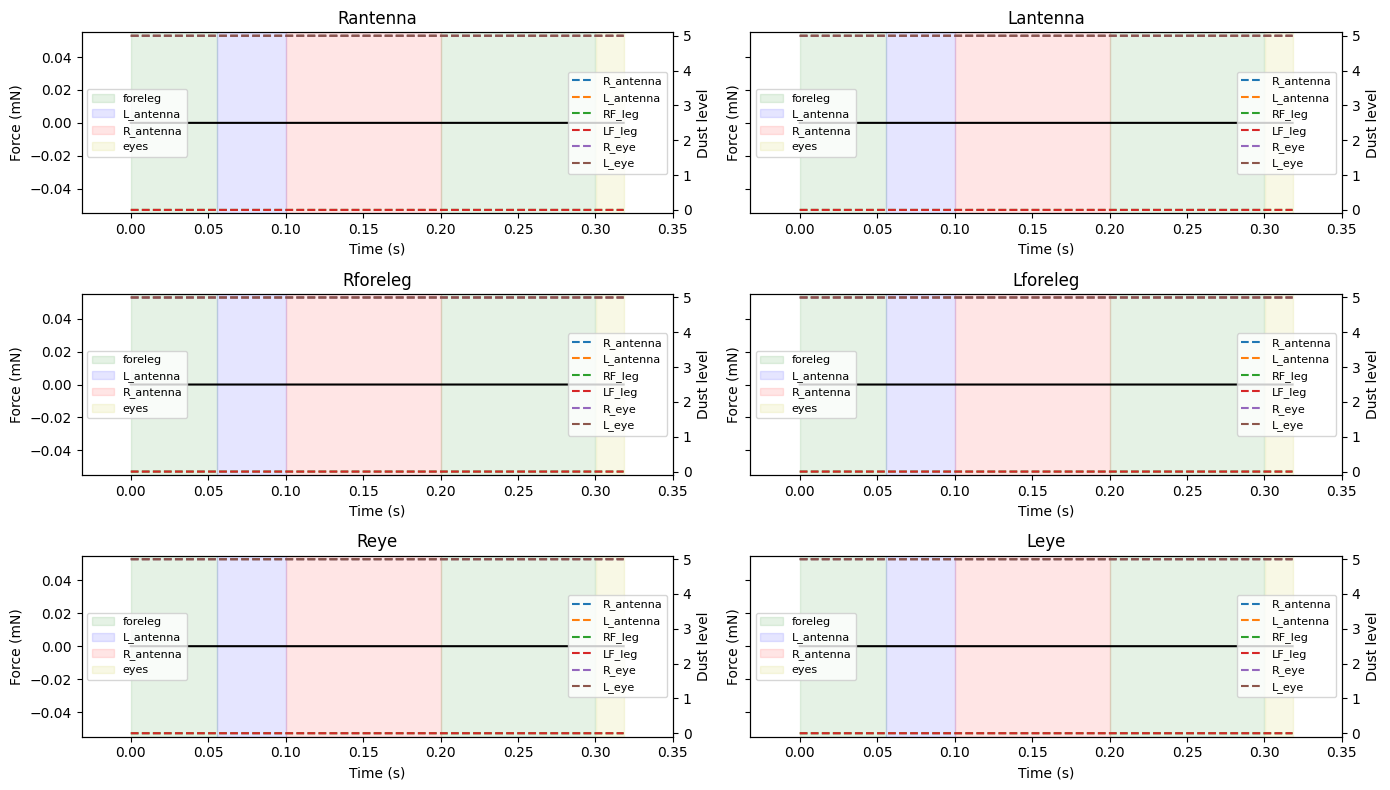

In [14]:
transition_period = 200
transit_to = ["foreleg", "L_antenna", "R_antenna", "foreleg", "eyes"]
transit_times = [0, 558, 1000, 2000, 3000]

# plot touch sensor traces
touch_sensor_data = np.array([obs["touch_sensors"] for obs in obs_list])
dust_levels = np.array([obs["dust_level"] for obs in obs_list])
time = np.arange(touch_sensor_data.shape[0]) * sim_params.timestep

# plot touch sensor traces
touch_sensor_data = np.array([obs["touch_sensors"] for obs in obs_list])
time = np.arange(touch_sensor_data.shape[0]) * sim_params.timestep
fig, _ = plot_state_and_contacts(
    time,
    touch_sensor_data,
    nmf.touch_sensor_locations,
    transit_to,
    transit_times,
    dust_levels,
    nmf.dusted_areas,
)